# Storage

This notebook illustrates how simulations and results can be saved to file.

In [ ]:
# install if not done yet
# %pip install pypesto --quiet

In [1]:
import pypesto
import pypesto.optimize as optimize
import pypesto.visualize as visualize
from pypesto.store import (save_to_hdf5, read_from_hdf5)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tempfile

%matplotlib inline

## Define the objective and problem

In [2]:
objective = pypesto.Objective(fun=sp.optimize.rosen, 
                              grad=sp.optimize.rosen_der, 
                              hess=sp.optimize.rosen_hess)

dim_full = 10
lb = -3 * np.ones((dim_full, 1))
ub = 3 * np.ones((dim_full, 1))

problem = pypesto.Problem(objective=objective, lb=lb, ub=ub)

# create optimizers
optimizer = optimize.ScipyOptimizer(method='l-bfgs-b')

# set number of starts
n_starts = 20

## Objective function traces

During optimization, it is possible to regularly write the objective function trace to file. This is useful e.g. when runs fail, or for various diagnostics. Currently, pyPESTO can save histories to 3 backends: in-memory, as CSV files, or to HDF5 files.

### Memory History

To record the history in-memory, just set `trace_record=True` in the `pypesto.HistoryOptions`. Then, the optimization result contains those histories:

In [3]:
# record the history
history_options = pypesto.HistoryOptions(trace_record=True)

# Run optimizaitons
result = optimize.minimize(
    problem=problem, optimizer=optimizer,
    n_starts=n_starts, history_options=history_options,
    filename=None)

  0%|          | 0/20 [00:00<?, ?it/s]Executing task 0.
Final fval=0.0000, time=0.0218s, n_fval=94.
Executing task 1.
Final fval=0.0000, time=0.0142s, n_fval=61.
Executing task 2.
Final fval=0.0000, time=0.0191s, n_fval=72.
Executing task 3.
Final fval=0.0000, time=0.0185s, n_fval=76.
Executing task 4.
Final fval=0.0000, time=0.0227s, n_fval=81.
 25%|██▌       | 5/20 [00:00<00:00, 48.89it/s]Executing task 5.
Final fval=0.0000, time=0.0258s, n_fval=83.
Executing task 6.
Final fval=0.0000, time=0.0270s, n_fval=90.
Executing task 7.
Final fval=3.9866, time=0.0278s, n_fval=77.
Executing task 8.
Final fval=0.0000, time=0.0308s, n_fval=98.
Executing task 9.
Final fval=0.0000, time=0.0256s, n_fval=96.
 50%|█████     | 10/20 [00:00<00:00, 39.43it/s]Executing task 10.
Final fval=0.0000, time=0.0224s, n_fval=68.
Executing task 11.
Final fval=0.0000, time=0.0172s, n_fval=64.
Executing task 12.
Final fval=0.0000, time=0.0220s, n_fval=79.
Executing task 13.
Final fval=0.0000, time=0.0277s, n_fval=9

Now, in addition to queries on the result, we can also access the

History type:  <class 'pypesto.objective.history.MemoryHistory'>


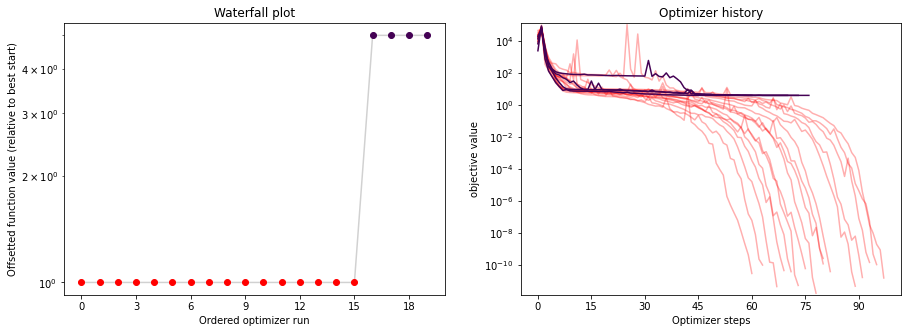

In [4]:
print("History type: ", type(result.optimize_result.list[0].history))
# print("Function value trace of best run: ", result.optimize_result.list[0].history.get_fval_trace())

fig, ax = plt.subplots(1, 2)
visualize.waterfall(result, ax=ax[0])
visualize.optimizer_history(result, ax=ax[1])
fig.set_size_inches((15, 5))

### CSV History

The in-memory storage is however not stored anywhere. To do that, it is possible to store either to CSV or HDF5. This is specified via the `storage_file` option. If it ends in `.csv`, a `pypesto.objective.history.CsvHistory` will be employed; if it ends in `.hdf5` a `pypesto.objective.history.Hdf5History`. Occurrences of the substring `{id}` in the filename are replaced by the multistart id, allowing to maintain a separate file per run (this is necessary for CSV as otherwise runs are overwritten).

In [5]:
# record the history and store to CSV
history_options = pypesto.HistoryOptions(trace_record=True, storage_file='history_{id}.csv')

# Run optimizaitons
result = optimize.minimize(
    problem=problem, optimizer=optimizer,
    n_starts=n_starts, history_options=history_options,
    filename=None)

  0%|          | 0/20 [00:00<?, ?it/s]Executing task 0.
Final fval=0.0000, time=1.3848s, n_fval=87.
  5%|▌         | 1/20 [00:01<00:26,  1.39s/it]Executing task 1.
Final fval=0.0000, time=1.0376s, n_fval=66.
 10%|█         | 2/20 [00:02<00:21,  1.18s/it]Executing task 2.
Final fval=0.0000, time=1.3995s, n_fval=87.
 15%|█▌        | 3/20 [00:03<00:21,  1.28s/it]Executing task 3.
Final fval=0.0000, time=1.3883s, n_fval=87.
 20%|██        | 4/20 [00:05<00:21,  1.33s/it]Executing task 4.
Final fval=0.0000, time=1.1283s, n_fval=74.
 25%|██▌       | 5/20 [00:06<00:18,  1.25s/it]Executing task 5.
Final fval=0.0000, time=1.2335s, n_fval=81.
 30%|███       | 6/20 [00:07<00:17,  1.25s/it]Executing task 6.
Final fval=3.9866, time=1.6121s, n_fval=106.
 35%|███▌      | 7/20 [00:09<00:17,  1.37s/it]Executing task 7.
Final fval=0.0000, time=1.2220s, n_fval=77.
 40%|████      | 8/20 [00:10<00:15,  1.32s/it]Executing task 8.
Final fval=0.0000, time=1.0812s, n_fval=71.
 45%|████▌     | 9/20 [00:11<00:13,

Note that for this simple cost function, saving to CSV takes a considerable amount of time. This overhead decreases for more costly simulators, e.g. using ODE simulations via AMICI.

History type:  <class 'pypesto.objective.history.CsvHistory'>


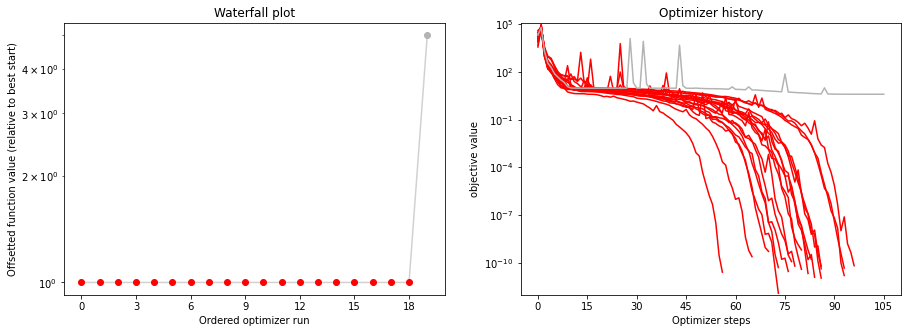

In [6]:
print("History type: ", type(result.optimize_result.list[0].history))
# print("Function value trace of best run: ", result.optimize_result.list[0].history.get_fval_trace())

fig, ax = plt.subplots(1, 2)
visualize.waterfall(result, ax=ax[0])
visualize.optimizer_history(result, ax=ax[1])
fig.set_size_inches((15, 5))

### HDF5 History

Just as in CSV, writing the history to HDF5 takes a considerable amount of time.
If a user specifies a HDF5 output file named `my_results.hdf5` and uses a parallelization engine, then:
* a folder is created to contain partial results, named `my_results/` (the stem of the output filename)
* files are created to store the results of each start, named `my_results/my_results_{START_INDEX}.hdf5`
* a file is created to store the combined result from all starts, named `my_results.hdf5`.
Note that this file depends on the files in the `my_results/` directory, so **cease to function** if
`my_results/` is deleted.

In [7]:
# record the history and store to CSV
history_options = pypesto.HistoryOptions(trace_record=True, storage_file='history.hdf5')

# Run optimizaitons
result = optimize.minimize(
    problem=problem, optimizer=optimizer,
    n_starts=n_starts, history_options=history_options,
    filename=None)

  0%|          | 0/20 [00:00<?, ?it/s]Executing task 0.
Final fval=0.0000, time=0.5606s, n_fval=322.
  5%|▌         | 1/20 [00:00<00:10,  1.78it/s]Executing task 1.
Final fval=3.9866, time=0.3860s, n_fval=280.
 10%|█         | 2/20 [00:00<00:08,  2.18it/s]Executing task 2.
Final fval=0.0000, time=0.5257s, n_fval=342.
 15%|█▌        | 3/20 [00:01<00:08,  2.04it/s]Executing task 3.
Final fval=0.0000, time=0.4912s, n_fval=333.
 20%|██        | 4/20 [00:01<00:07,  2.04it/s]Executing task 4.
Final fval=3.9866, time=0.3889s, n_fval=324.
 25%|██▌       | 5/20 [00:02<00:06,  2.20it/s]Executing task 5.
Final fval=0.0000, time=0.4808s, n_fval=345.
 30%|███       | 6/20 [00:02<00:06,  2.15it/s]Executing task 6.
Final fval=0.0000, time=0.4517s, n_fval=322.
 35%|███▌      | 7/20 [00:03<00:05,  2.17it/s]Executing task 7.
Final fval=0.0000, time=0.5006s, n_fval=347.
 40%|████      | 8/20 [00:03<00:05,  2.11it/s]Executing task 8.
Final fval=0.0000, time=0.4723s, n_fval=311.
 45%|████▌     | 9/20 [00:0

History type:  <class 'pypesto.objective.history.Hdf5History'>


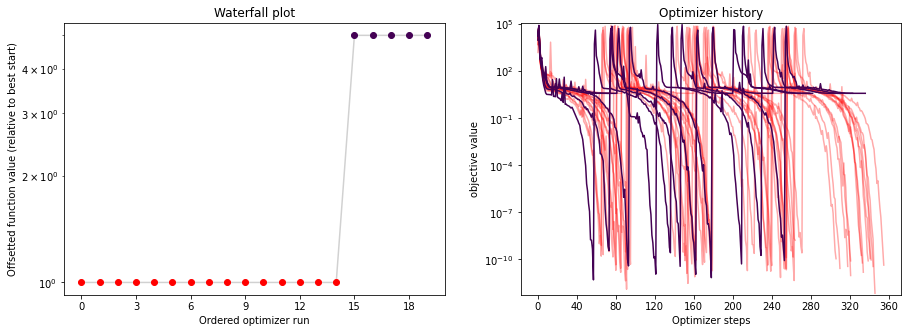

In [8]:
print("History type: ", type(result.optimize_result.list[0].history))
# print("Function value trace of best run: ", result.optimize_result.list[0].history.get_fval_trace())

fig, ax = plt.subplots(1, 2)
visualize.waterfall(result, ax=ax[0])
visualize.optimizer_history(result, ax=ax[1])
fig.set_size_inches((15, 5))

## Result storage

Result objects can be stored as HDF5 files. When applicable, this is preferable to just pickling results, which is
not guaranteed to be reproducible in the future.

In [9]:
# Run optimizaitons
result = optimize.minimize(
    problem=problem, optimizer=optimizer,
    n_starts=n_starts, filename=None)

  0%|          | 0/20 [00:00<?, ?it/s]Executing task 0.
Final fval=3.9866, time=0.0118s, n_fval=48.
Executing task 1.
Final fval=3.9866, time=0.0201s, n_fval=90.
Executing task 2.
Final fval=0.0000, time=0.0210s, n_fval=100.
Executing task 3.
Final fval=0.0000, time=0.0164s, n_fval=73.
Executing task 4.
Final fval=0.0000, time=0.0174s, n_fval=76.
Executing task 5.
Final fval=0.0000, time=0.0155s, n_fval=71.
 30%|███       | 6/20 [00:00<00:00, 55.46it/s]Executing task 6.
Final fval=0.0000, time=0.0190s, n_fval=87.
Executing task 7.
Final fval=0.0000, time=0.0195s, n_fval=88.
Executing task 8.
Final fval=0.0000, time=0.0177s, n_fval=79.
Executing task 9.
Final fval=3.9866, time=0.0179s, n_fval=83.
Executing task 10.
Final fval=0.0000, time=0.0188s, n_fval=86.
Executing task 11.
Final fval=3.9866, time=0.0202s, n_fval=84.
 60%|██████    | 12/20 [00:00<00:00, 52.23it/s]Executing task 12.
Final fval=3.9866, time=0.0188s, n_fval=82.
Executing task 13.
Final fval=0.0000, time=0.0211s, n_fval=

In [10]:
result.optimize_result.list[0:2]

[{'id': '4',
  'x': array([1.00000001, 1.        , 1.        , 0.99999999, 0.99999999,
         1.00000001, 1.00000001, 1.00000004, 1.00000008, 1.00000014]),
  'fval': 2.6045655152986313e-13,
  'grad': array([ 7.38459033e-06, -4.78320167e-07, -6.50914679e-07, -1.47726642e-06,
         -1.39575141e-05,  9.14793168e-06, -7.58437136e-06,  4.50055738e-07,
          1.01219510e-05, -4.24214104e-06]),
  'hess': None,
  'res': None,
  'sres': None,
  'n_fval': 76,
  'n_grad': 76,
  'n_hess': 0,
  'n_res': 0,
  'n_sres': 0,
  'x0': array([ 0.33383114,  2.09297901, -1.77381628, -1.60663808, -2.85350433,
          0.71050093, -1.190691  ,  0.91974885, -2.34344618,  1.21791823]),
  'fval0': 18119.670540771178,
  'history': <pypesto.objective.history.History at 0x7ffd399536a0>,
  'exitflag': 0,
  'time': 0.017375946044921875,
  'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 {'id': '16',
  'x': array([1.        , 1.        , 1.00000001, 1.        , 1.00000001,
         1.00000003, 

As usual, having obtained our result, we can directly perform some plots:

<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Offsetted function value (relative to best start)'>

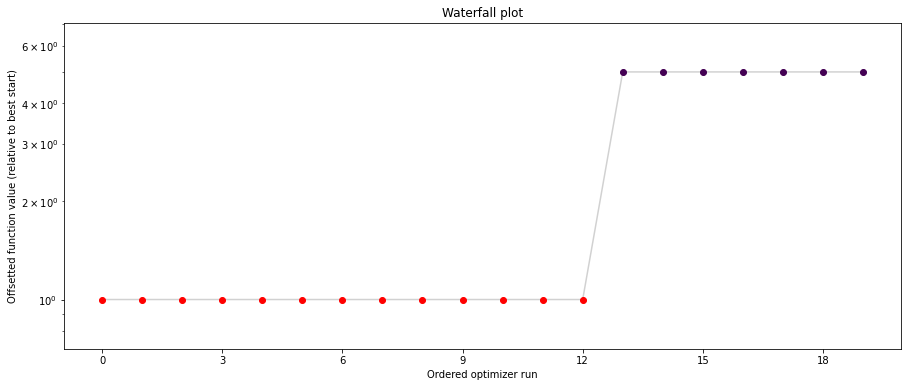

In [11]:
# plot waterfalls
visualize.waterfall(result, size=(15,6))

### Save optimization result as HDF5 file

The optimization result can be saved with `pypesto.store.write_result()`. This will write the problem and the
optimization result, and the profiling and sampling results if available, to HDF5.
All of them can be disabled with boolean flags
(see [the documentation](https://pypesto.readthedocs.io/en/latest/api_store.html#pypesto.store.write_result))

In [12]:
fn = tempfile.mktemp(".hdf5")

# Write result
save_to_hdf5.write_result(result, fn)

### Read optimization result from HDF5 file

When reading in the stored result again, we recover the original optimization result:

In [13]:
# Read result and problem
result = read_from_hdf5.read_result(fn)

This problem is not to be used without a separately created objective.
This problem is not to be used without a separately created objective.
This problem is not to be used without a separately created objective.
This problem is not to be used without a separately created objective.
Loading the sampling result failed. It is highly likely that no sampling result exists within /var/folders/2f/bnywv1ns2_9g8wtzlf_74yzh0000gn/T/tmpewjf65r6.hdf5.


In [14]:
result.optimize_result.list[0:2]

[{'id': '4',
  'x': array([1.00000001, 1.        , 1.        , 0.99999999, 0.99999999,
         1.00000001, 1.00000001, 1.00000004, 1.00000008, 1.00000014]),
  'fval': 2.6045655152986313e-13,
  'grad': array([ 7.38459033e-06, -4.78320167e-07, -6.50914679e-07, -1.47726642e-06,
         -1.39575141e-05,  9.14793168e-06, -7.58437136e-06,  4.50055738e-07,
          1.01219510e-05, -4.24214104e-06]),
  'hess': None,
  'res': None,
  'sres': None,
  'n_fval': 76,
  'n_grad': 76,
  'n_hess': 0,
  'n_res': 0,
  'n_sres': 0,
  'x0': array([ 0.33383114,  2.09297901, -1.77381628, -1.60663808, -2.85350433,
          0.71050093, -1.190691  ,  0.91974885, -2.34344618,  1.21791823]),
  'fval0': 18119.670540771178,
  'history': None,
  'exitflag': 0,
  'time': 0.017375946044921875,
  'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 {'id': '16',
  'x': array([1.        , 1.        , 1.00000001, 1.        , 1.00000001,
         1.00000003, 1.00000007, 1.00000009, 1.00000017, 1.00000039]),

<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Offsetted function value (relative to best start)'>

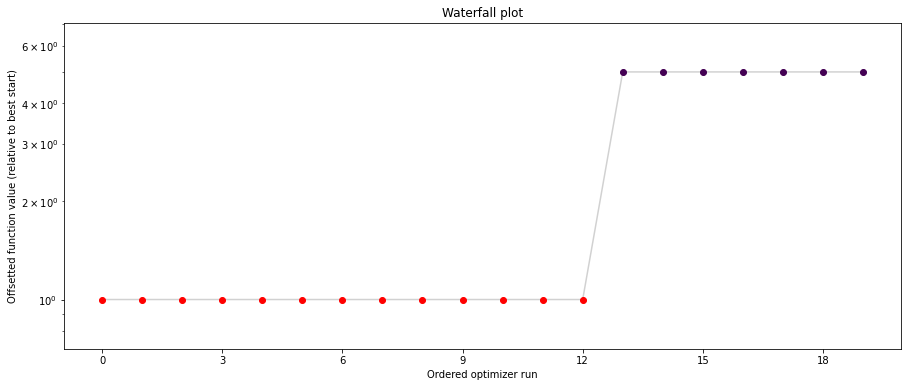

In [15]:
# plot waterfalls
pypesto.visualize.waterfall(result, size=(15,6))